# Explore Data

The first step is exploring data to understand what would be a proper problem setting!

In [1]:
import pandas as pd

dfs = []
for i in range(5):
    df = pd.read_csv(f'outputs/output_res_2019061{i}.csv', index_col='timestamp')
    dfs.append(df)

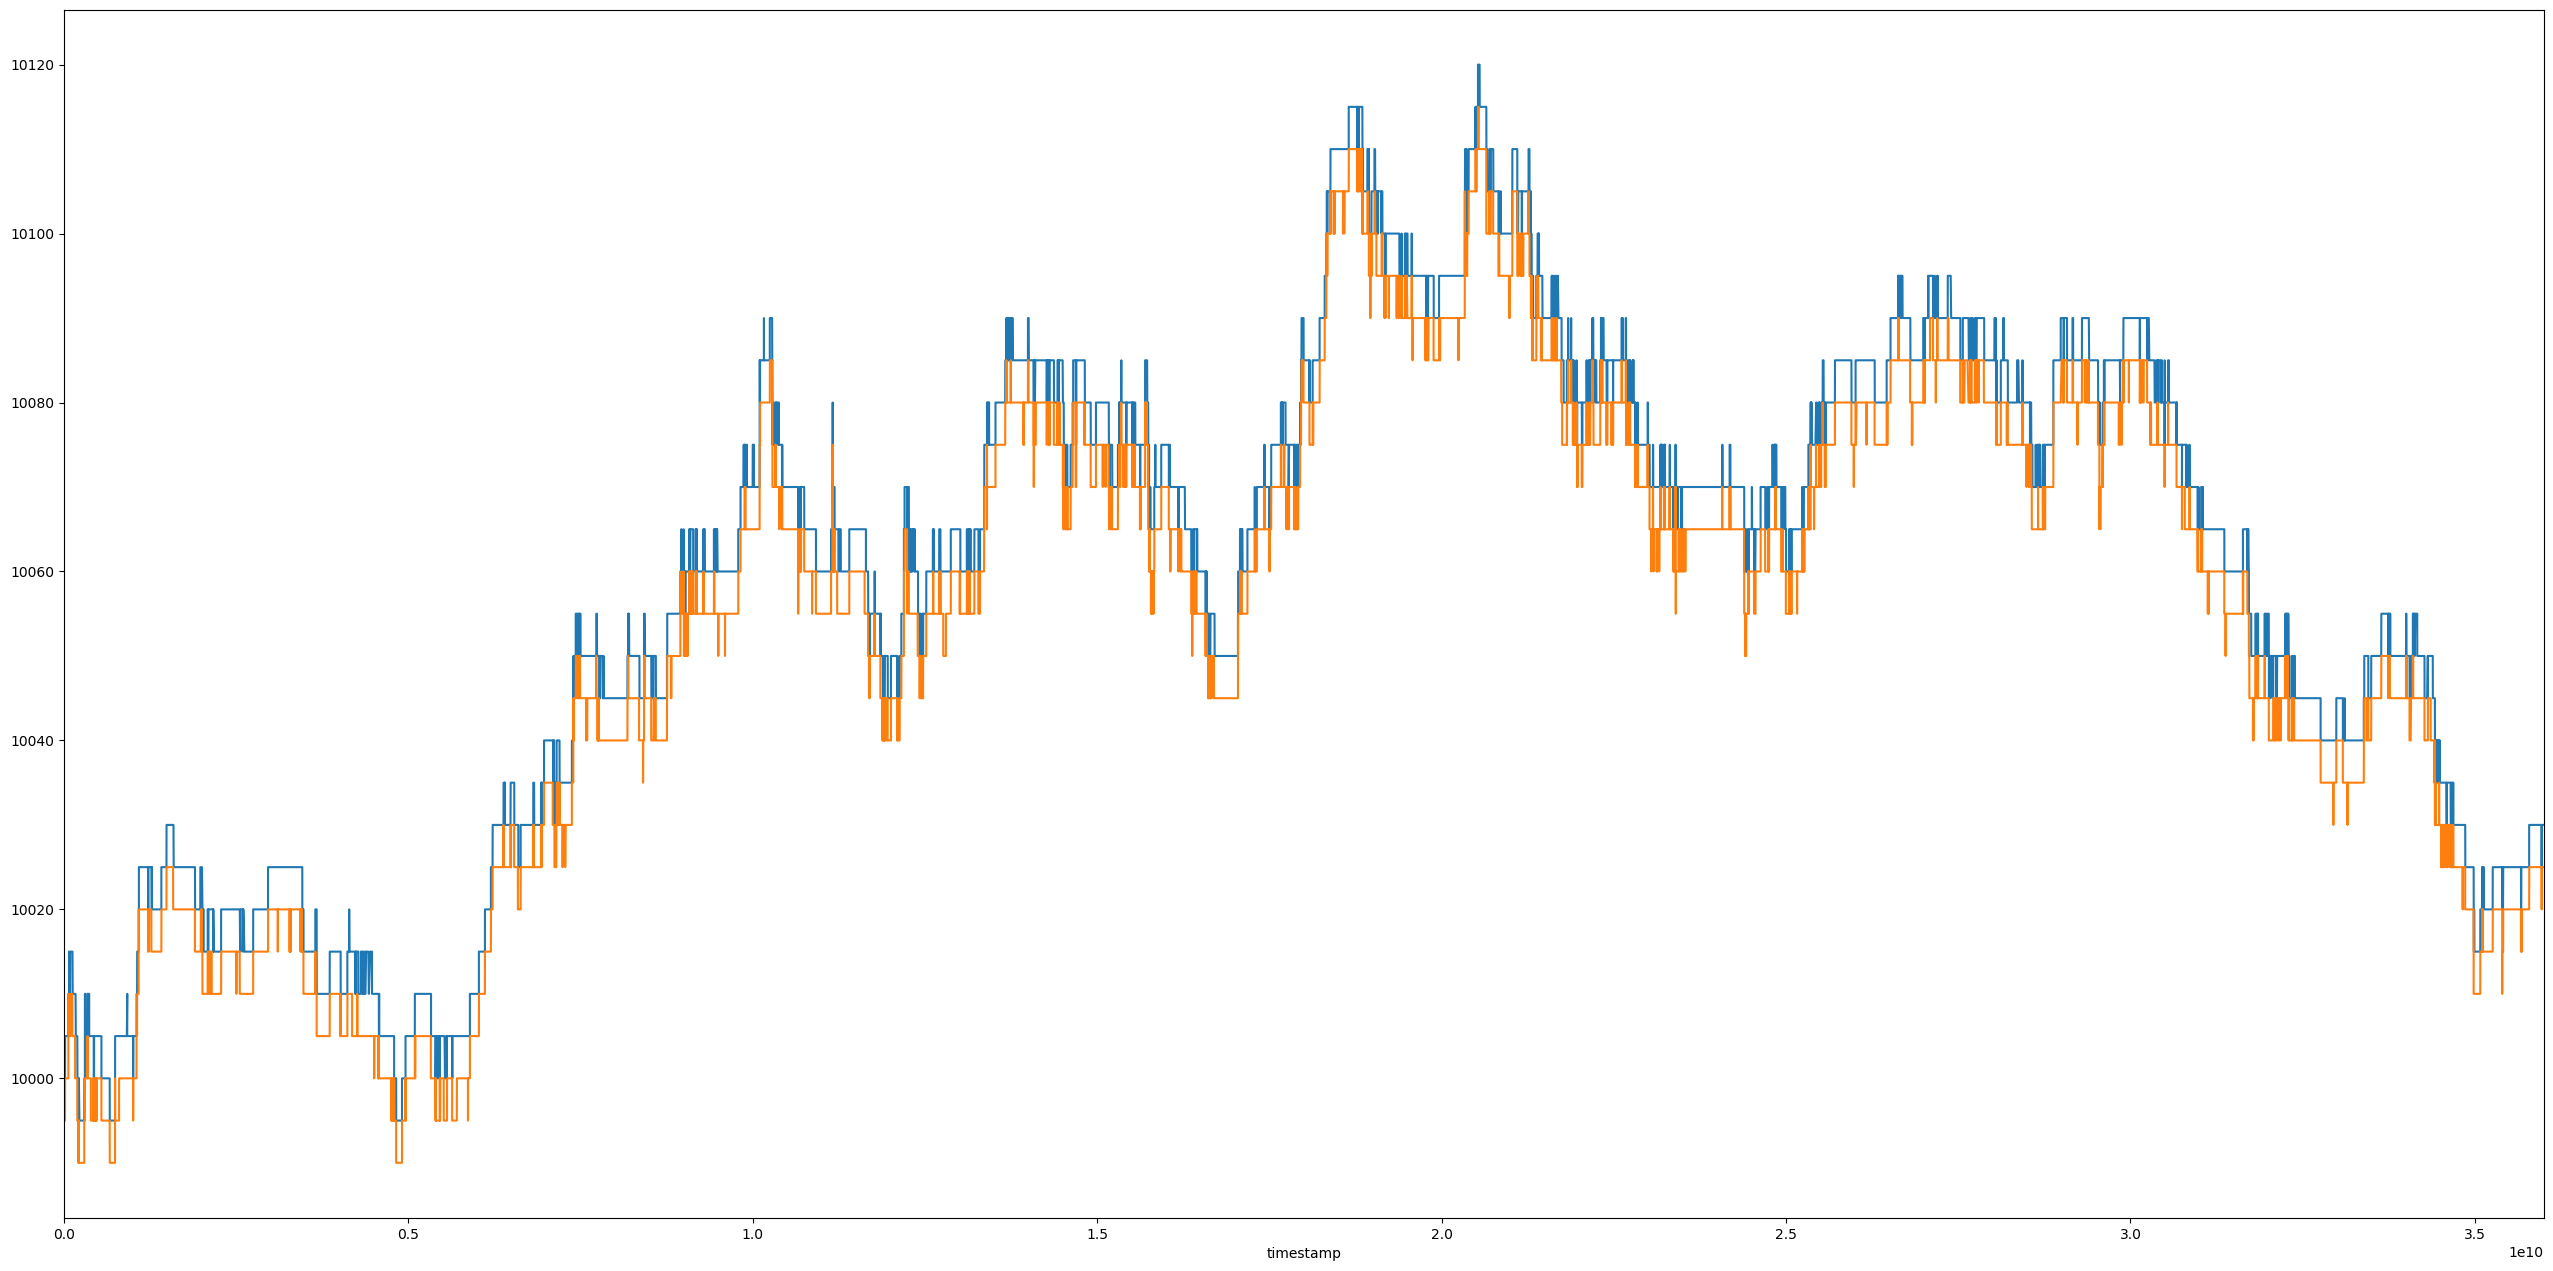

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

dfs[0]['ap0'].plot()
dfs[0]['bp0'].plot()

In [3]:
quantities = [df['quantity'].sum() for df in dfs]
quantities

[345951, 574523, 730994, 727386, 753507]

In [4]:
lengths = [(df.index[-1] - df.index[0]) * 1e-6 for df in dfs]
lengths

[36000.0, 36000.0, 36000.0, 36000.0, 35999.621353999995]

In [5]:
ask_diffs = [df['ap0'].diff().fillna(0).unique() for df in dfs]
bid_diffs = [df['bp0'].diff().fillna(0).unique() for df in dfs]
print(ask_diffs)
print(bid_diffs)

[array([  0.,   5.,  -5., -10.,  10.]), array([  0.,  -5.,   5., -10.]), array([  0.,  -5.,   5., -10.]), array([  0., -15.,   5.,  -5., -10.,  10.]), array([  0.,   5.,  -5., -15., -10.])]
[array([ 0.,  5., -5., 10.]), array([ 0., -5.,  5.]), array([ 0., -5.,  5., 10.]), array([ 0., -5.,  5.]), array([  0.,   5.,  -5.,  10., -10.])]


In [6]:
ask_diffs = [df['ap0'].diff().fillna(0) for df in dfs]
ask_diffs = [x[x != 0].shape[0] for x in ask_diffs]
ask_diffs = [lengths[i] / ask_diffs[i] for i in range(len(lengths))]
bid_diffs = [df['bp0'].diff().fillna(0) for df in dfs]
bid_diffs = [x[x != 0].shape[0] for x in bid_diffs]
bid_diffs = [lengths[i] / bid_diffs[i] for i in range(len(lengths))]
print(ask_diffs)
print(bid_diffs)

[27.54399387911247, 13.595166163141993, 11.225444340505145, 11.494252873563218, 11.873226040237466]
[15.901060070671377, 13.688212927756654, 11.331444759206798, 10.650887573964496, 8.65167540350877]


In [7]:
[df['aq0'].mean() for df in dfs]

[24.788532609087177,
 48.15029024682058,
 50.452229299363054,
 47.21140255684074,
 40.086708954335805]

In [8]:
[df['bq0'].mean() for df in dfs]

[43.48558132163414,
 51.89983914351677,
 50.70632233653632,
 48.823602367042895,
 44.94316026339134]

From the above result, we understand that each data set is 10 hours length and its tick size is 5.
For prediction problem, we can consider either of classification or regression. For regression, we can use the signal for fair price estimation, which would be helpful to make quanting for market making. This process usually comes with backtest result to evaluate the quality. In this project, we will use classification to evaluate prediction quality. Since this task is supposed to use Lasso, we will use threashold to translate outputs into classification ones.

# Feature Engineering

If we consider executing order with market order, at least we need to pay the spread. The minimum round trip in this case is 2 ticks, 10. We need to consider movement more thatn 3 ticks to make profits.

Let's consider the simple binary classification case.
We assume that we will get threashold - spread for winning and -threashold - spread for loosing. In this setting,
our profit is p * (threashold - 2 * spread) + (1 - p)*(-threashold - 2 * spread), where p is winning probability.

To get positive pnl, p have to be larger thatn 0.5 * (1 + 2 * spread/threashold). Let's do some experiments.

In [9]:
from helper import calc_return


def optimal_probability(df, period, th, spread=5):
    """ Calculate the lowest required accuracy when betting"""
    returns = calc_return(df, period).dropna()
    pos_ret = returns[returns >= th].values.mean()
    neg_ret = returns[returns <= -th].values.mean()
    wrong_pos_ret = returns[returns < th].values.mean()
    wrong_neg_ret = returns[returns > -th].values.mean()
    # pnl = (profit - 2 * spread) * p + (-loss - 2 * spread) (1 - p) > 0
    # (profit + loss) * p > loss + 2 * spread
    profit = pos_ret - neg_ret
    loss = -wrong_pos_ret + wrong_neg_ret
    p = (loss + 2 * spread) / (profit + loss)
    params = {
        'period': period,
        'th': th,
        'spread': spread,
    }
    return p, params

In [10]:
from helper import multi_grid_execution
import numpy as np

ths = np.arange(1, 6) * 5
periods = np.logspace(6, 9, 10)
params_conf = [   
    {'name': 'th',  'domain': ths},
    {'name': 'period', 'domain': periods},
]

default_params = {
    'df': df,
}

output = multi_grid_execution(params_conf, optimal_probability, default_params)

/Users/tomfujii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/tomfujii/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tomfujii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/Users/tomfujii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/tomfujii/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tomfujii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/Users/tomfujii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/Users/tomfujii/a

In [12]:
scores = np.zeros((len(periods), len(ths)))
for i, period in enumerate(periods):
    for j, th in enumerate(ths):
        for x in output:
            if x[1]['period'] == period and x[1]['th'] == th:
                scores[i][j] = x[0]
                break

Text(370.72222222222223, 0.5, 'period')

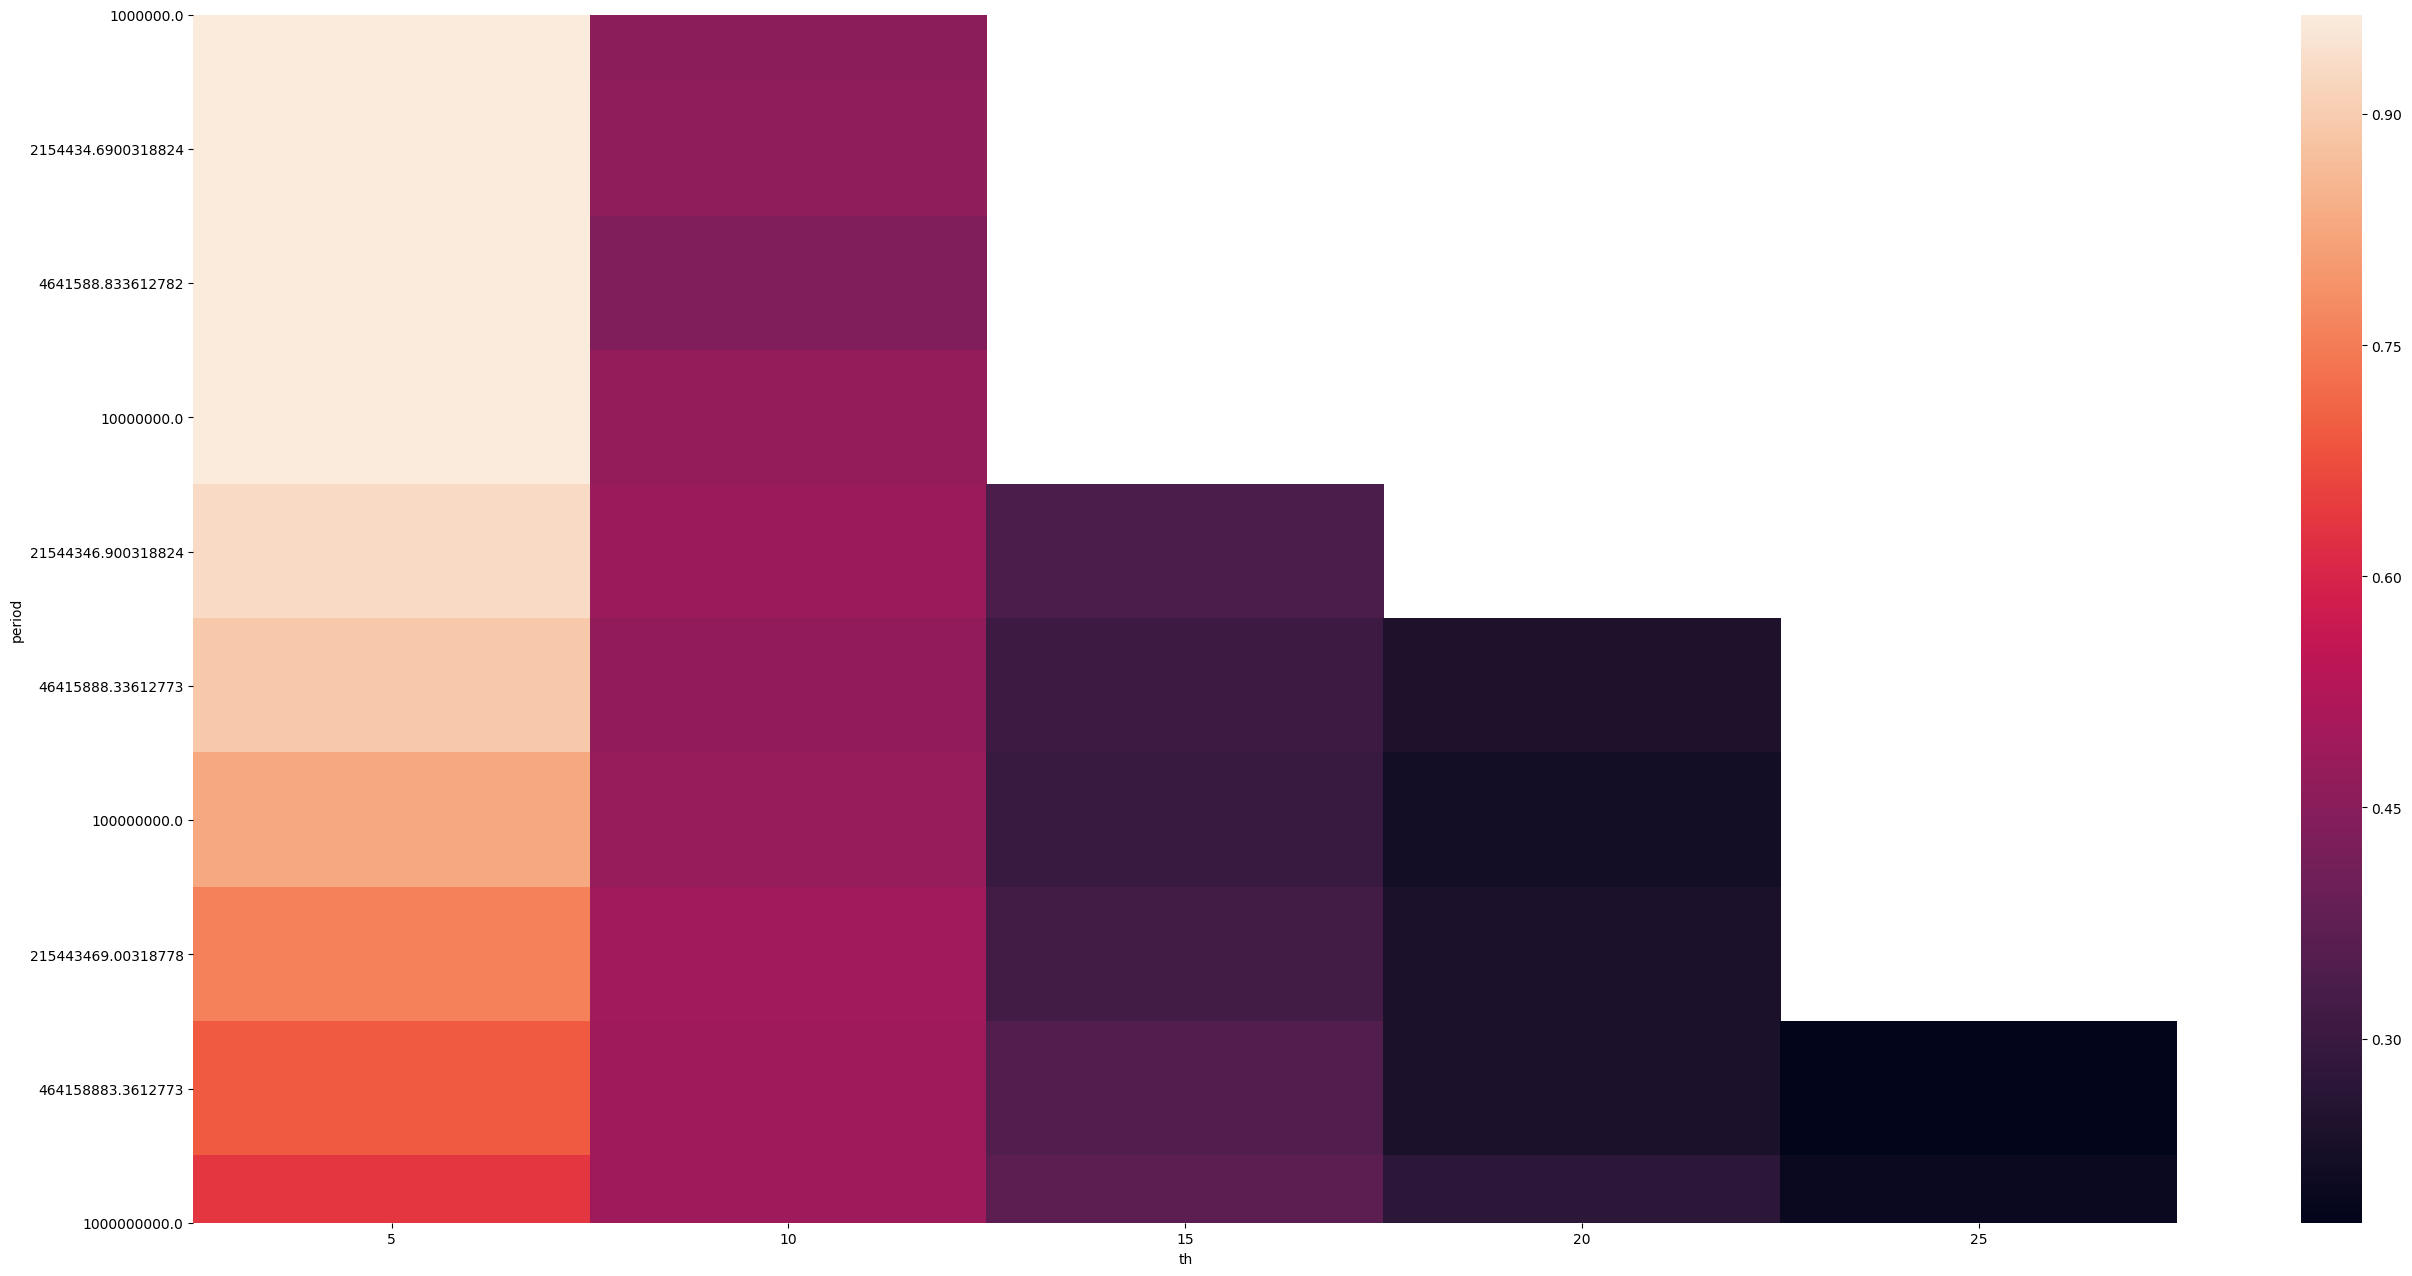

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.heatmap(scores, yticklabels=periods, xticklabels=ths)
plt.xlabel("th")
plt.ylabel("period")

In [16]:
from helper import calc_return

def calc_return_ratio(df, period, th):
    returns = calc_return(df, period)
    returns = returns.dropna()
    returns = returns.loc[~returns.index.duplicated(keep='last')]
    ratio = returns.loc[np.abs(returns) >= th].shape[0] / returns.shape[0]
    num_opp = (df.index[-1] - df.index[0]) / period
    return ratio, num_opp, period

In [17]:
import numpy as np
from tqdm import tqdm_notebook

periods = np.logspace(6, 9, 20)
th = 20
ratios = []
num_opportunities = []
for period in tqdm_notebook(periods):
    results = [calc_return_ratio(df, period, th) for df in dfs]
    ratio = np.mean([x[0] for x in results])
    num_opp = np.mean([x[1] for x in results])
    ratios.append(ratio)
    num_opportunities.append(num_opp)

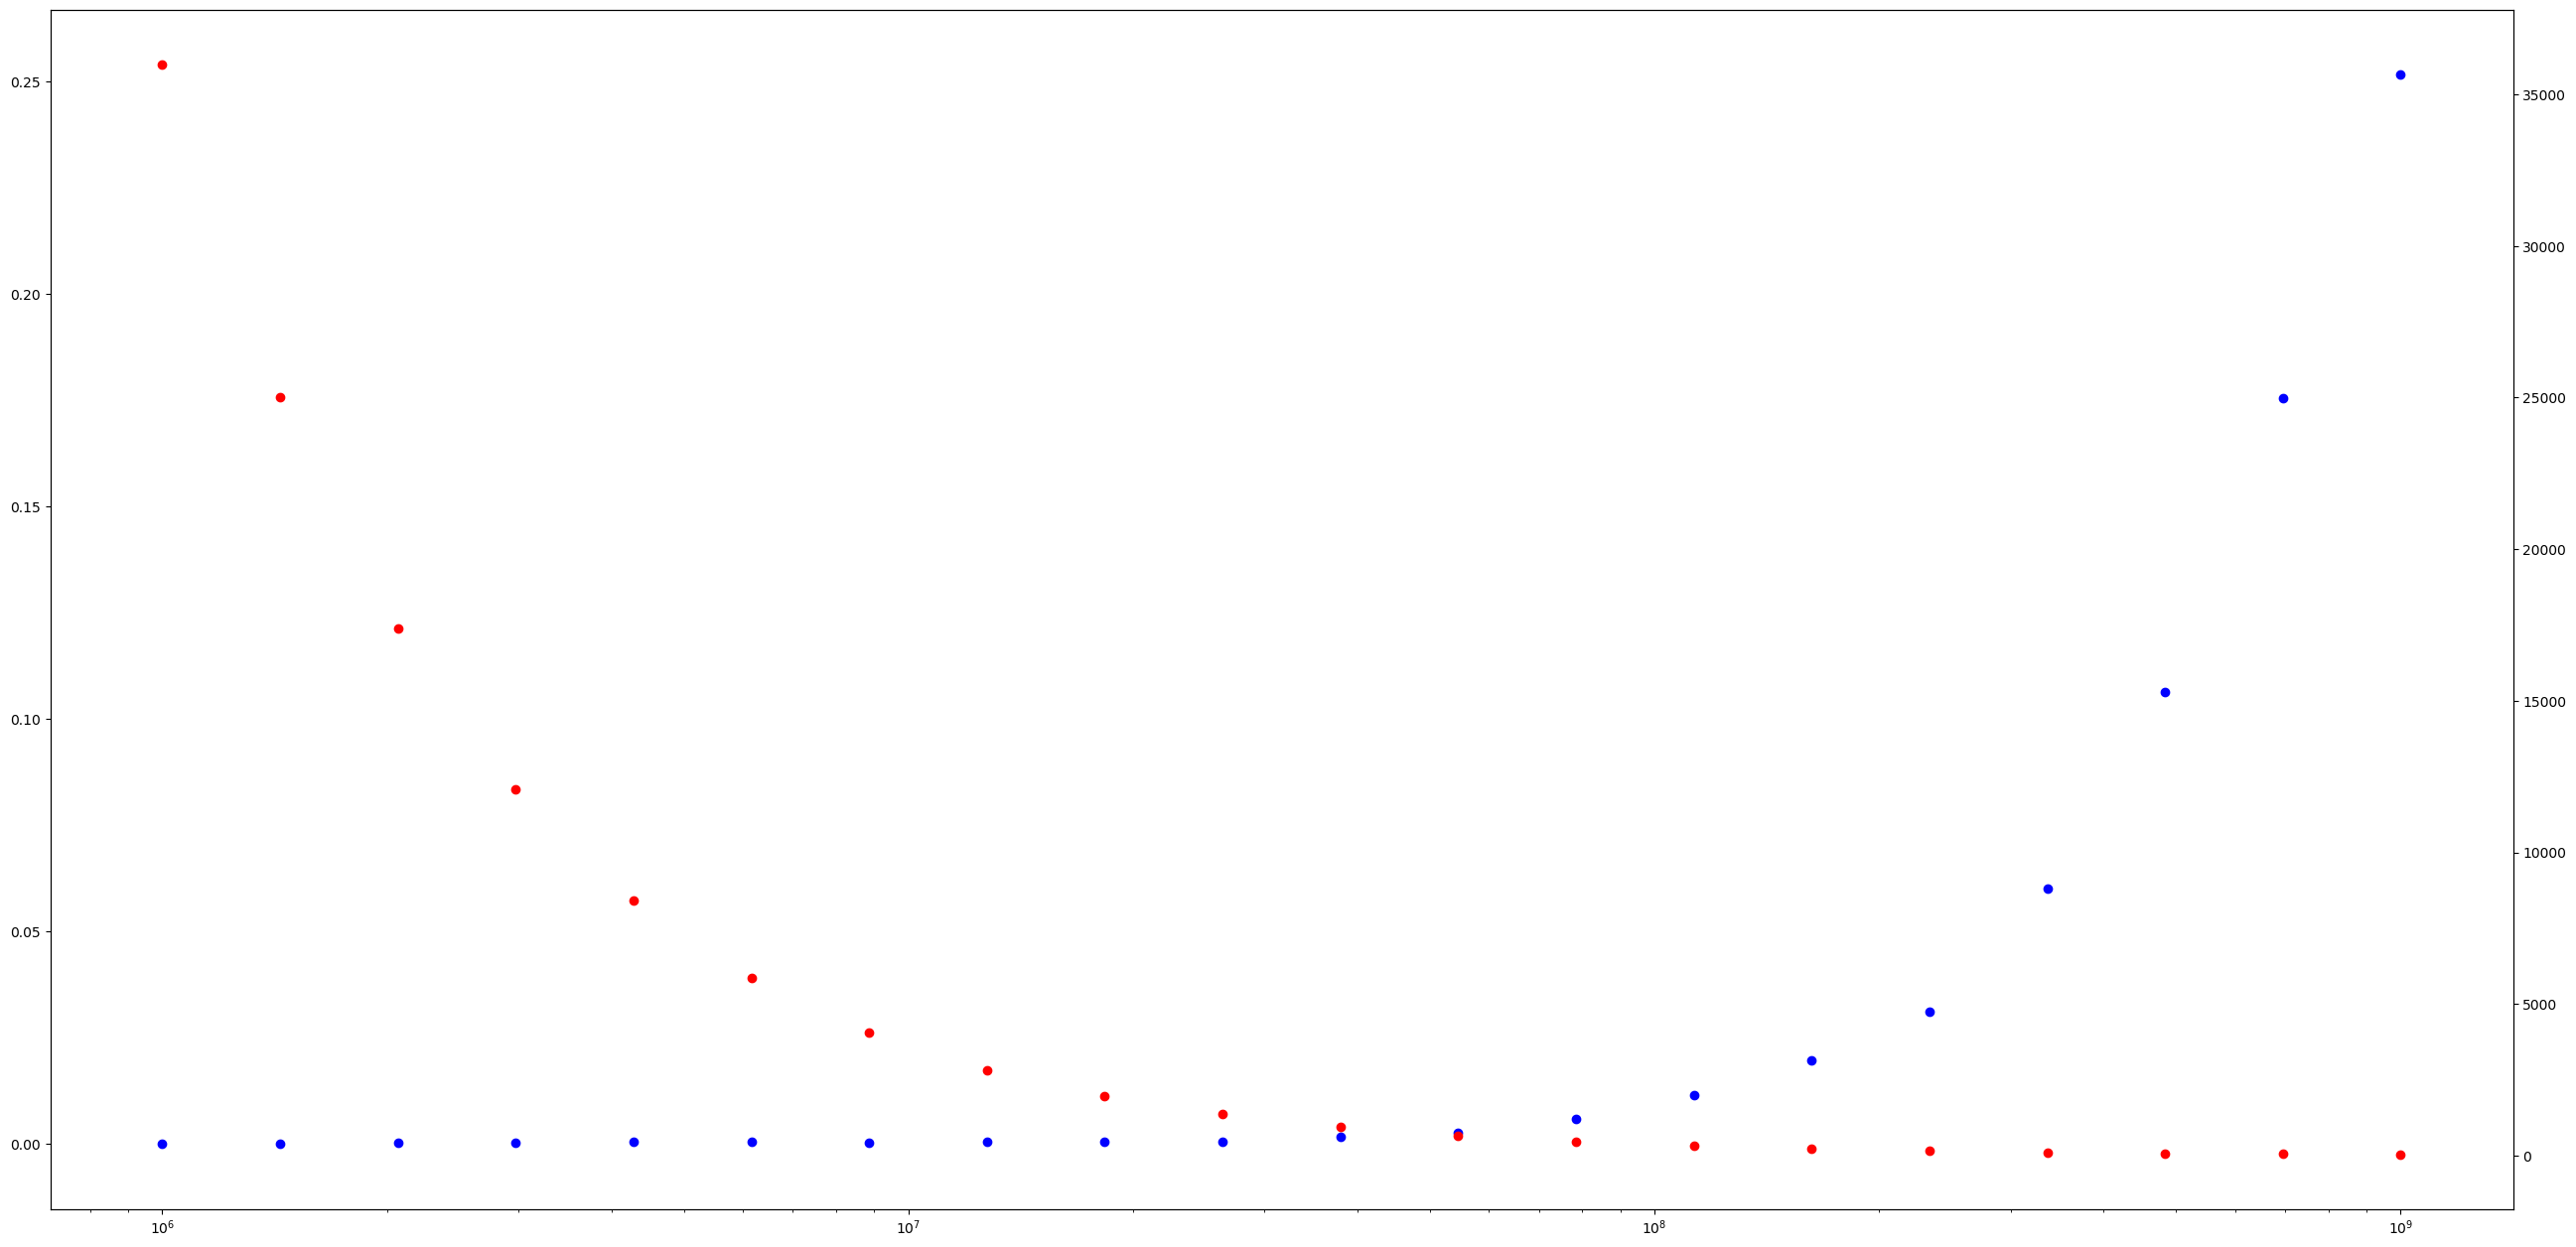

In [18]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(periods, ratios, label='ratio', color='b')
ax2.scatter(periods, num_opportunities, label='num_opp', color='r')
plt.xscale('log')

In [19]:
for i in range(len(periods)):
    print(periods[i], ratios[i])
print('*'*100)
for i in range(len(periods)):
    print(periods[i], num_opportunities[i])

1000000.0 0.00015289692874795096
1438449.888287663 6.448740831346706e-05
2069138.0811147902 0.0004129274371039745
2976351.441631319 0.0004129274371039745
4281332.3987193955 0.0004482914997274887
6158482.110660267 0.0006542351585350125
8858667.904100832 0.0002683686928156245
12742749.857031321 0.0006043747997553374
18329807.108324375 0.0005232519432099999
26366508.987303555 0.0006749842802154643
37926901.90732254 0.0017765394621406575
54555947.811685145 0.0027630160867418534
78475997.03514607 0.0060209752118658665
112883789.16846883 0.011533883971154195
162377673.91887176 0.019820632431909596
233572146.90901214 0.03119063395379667
335981828.6283788 0.060126406289019885
483293023.85717523 0.1064413277242777
695192796.1775591 0.17549967953234585
1000000000.0 0.2515313832845714
****************************************************************************************************
1000000.0 36000.0
1438449.888287663 25026.94066239218
2069138.0811147902 17398.548858858307
2976351.441631319 1209

From the above results, it would be reasonable to consider 3e8 with 4 spread, 20.

Next, I consider some basic features, Order Flow Imbalance at BBO, Volume Imbalance at BBO, zscore from smoothed price. These features have parameters to either of summing up or smoothing out.

In [10]:
from helper import calc_smooth_stats, smooth_signals, calc_order_flow_imbalacne, calc_return, grid_samples
from helper import multi_grid_execution
import multiprocessing as mp
import numpy as np

def generate_features(df, period):
    features = dict()
    mid_prices = 0.5 * (df['ap0'] + df['bp0'])
    spread = df['ap0'] - df['bp0']
    volume_imb = df['bq0'] - df['aq0']
    mean_prices, vols, zscores = calc_smooth_stats(mid_prices, period)
    features['vol'] = vols
    features['zscore'] = zscores
    ofi = calc_order_flow_imbalacne(df, period)
    features['ofi'] = ofi
    smooth_volume_imb = smooth_signals(volume_imb, period)
    features['volume_imbalance'] = smooth_volume_imb
    return pd.DataFrame(features), period

def generate_features_multi_periods(df, periods):
    features = dict()
    params_conf = [   
        {'name': 'period',  'domain': periods},
    ]

    default_params = {
        'df': df,
    }

    output = multi_grid_execution(params_conf, generate_features, default_params, num_threads=4)
    for x in output:
        features_ = x[0]
        period = x[1]
        for col in features_.columns:
            features[f'{col}_{period}'] = features_[col]
    features = pd.DataFrame(features)
    return features

In [11]:
from tqdm import tqdm_notebook
periods = np.logspace(6, 9, 10)

features = [generate_features_multi_periods(df, periods) for df in tqdm_notebook(dfs)]

2019-12-14 00:59:13.272025 100.0% task done after 1.24 minutes. Remaining 0.0 minutes.
2019-12-14 01:01:16.552940 100.0% task done after 2.05 minutes. Remaining 0.0 minutes.
2019-12-14 01:03:47.562672 100.0% task done after 2.52 minutes. Remaining 0.0 minutes.


2019-12-14 01:06:13.923623 100.0% task done after 2.44 minutes. Remaining 0.0 minutes.


Before jumping into prediction, we will look into feature importance to reduce the dimension of features.

In [16]:
from helper import calc_smooth_stats, smooth_signals, calc_order_flow_imbalacne, calc_return

def generate_labels(df, period, th):
    returns = calc_return(df, period)
    labels = pd.Series(0, index=returns.index)
    labels[np.abs(returns) >= th] = 1
    labels[returns <= -th] = -1
    return labels

In [17]:
period = 3e8
th = 20
labels = [generate_labels(df, period, th) for df in dfs]

In [29]:
from sklearn.ensemble import RandomForestClassifier
from helper import feat_imp_MDA

clf = RandomForestClassifier(n_jobs=4, n_estimators=100)
results = feat_imp_MDA(clf, features, labels)

/Users/tomfujii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/tomfujii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/tomfujii/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning,

In [56]:
scores = results[0]['mean']
scores.sort_values(ascending=False)

ofi_464158883.3612773                  1.213733e-02
ofi_1000000000.0                       7.110624e-03
ofi_21544346.900318824                 4.628926e-03
volume_imbalance_10000000.0            2.875886e-03
ofi_10000000.0                         1.953105e-03
volume_imbalance_2154434.6900318824    1.194477e-03
vol_215443469.00318778                 8.778485e-04
volume_imbalance_1000000.0             8.635097e-04
zscore_215443469.00318778              7.413378e-04
vol_464158883.3612773                  5.772380e-04
ofi_2154434.6900318824                 5.750629e-04
ofi_4641588.833612782                  3.743847e-04
vol_46415888.33612773                  6.686024e-05
volume_imbalance_215443469.00318778    5.436363e-05
vol_100000000.0                        3.657197e-05
vol_4641588.833612782                  2.014355e-05
vol_2154434.6900318824                 2.598124e-06
vol_1000000000.0                       9.180857e-07
ofi_1000000.0                         -3.019608e-05
vol_1000000.

In [58]:
select_names = scores[scores > 0].index
select_names

Index(['ofi_10000000.0', 'volume_imbalance_10000000.0',
       'vol_2154434.6900318824', 'ofi_2154434.6900318824',
       'volume_imbalance_2154434.6900318824', 'volume_imbalance_1000000.0',
       'vol_4641588.833612782', 'ofi_4641588.833612782',
       'ofi_21544346.900318824', 'vol_46415888.33612773',
       'vol_215443469.00318778', 'zscore_215443469.00318778',
       'volume_imbalance_215443469.00318778', 'vol_100000000.0',
       'vol_464158883.3612773', 'ofi_464158883.3612773', 'vol_1000000000.0',
       'ofi_1000000000.0'],
      dtype='object')

We use positive importance features!

In [59]:
select_features = [feature[select_names] for feature in features]

# Generate Models

In [146]:
def evaluate(model, features, returns, th=20, spread=5):
    
    pred = model.predict_clf(features, th)
    # Proxy of PnL
    score = returns.values * pred - 2 * spread * np.abs(pred)
    score = np.mean(score)
    return score

def validation(model, features, dfs, period, th=20, spread=5, **kwargs):
    scores = []
    returns = [calc_return(df, period) for df in dfs]
    for i in range(len(features)):
        test_df = features[i]
        test_label = returns[i]
        X_test = test_df.loc[~test_df.index.duplicated()]
        y_test = test_label.loc[~test_label.index.duplicated()]
        cond = (~y_test.isnull()) & (X_test.isnull().sum(axis=1) == 0)
        X_test = X_test.loc[cond]
        y_test = y_test.loc[cond]
        X_train = []
        y_train = []
        for j in range(len(features)):
            if i == j:
                continue
            df = features[j]
            label = returns[j]
            df = df.loc[~df.index.duplicated()]
            label = label.loc[~label.index.duplicated()]
            cond = (~label.isnull()) & (df.isnull().sum(axis=1) == 0)
            df = df.loc[cond]
            label = label.loc[cond]
            X_train.append(df)
            y_train.append(label)
        X_train = pd.concat(X_train)
        y_train = pd.concat(y_train)
        # Add hoc down sampling
        y_ = y_train.loc[np.abs(y_train) >= th]
        X_ = X_train.loc[np.abs(y_train) >= th]
        X0 = X_train.loc[np.abs(y_train) < th]
        y0 = y_train.loc[np.abs(y_train) < th]
        y_size = max(len(y_), 1e-2 * len(y0))
        sample_freq = int(max(len(y0) / y_size, 1))
        X0 = X0.iloc[::sample_freq]
        y0 = y0.iloc[::sample_freq]
        X_ = pd.concat((X_, X0))
        y_ = pd.concat((y_, y0))
        model.fit(X_.values, y_.values)
        score = evaluate(model, X_test, y_test, th=th, spread=spread)
        scores.append(score)
    return np.mean(scores)

def model_selection(select_features, dfs, period, th, **kwargs):
    model = Model(**kwargs)
    score = validation(model, select_features, dfs, period, th)
    params = {
        'period': period,
        'th': th,
    }
    params.update(kwargs)
    return score, params

def multi_model_selection(select_features, dfs, params_conf):
    default_params = {
        'dfs': dfs,
        'select_features': select_features,
    }

    output = multi_grid_execution(params_conf, model_selection, default_params)
    return output

In [ ]:
alphas = np.logspace(-3, 1, 5)
periods = np.logspace(8, 9, 2)
ths = [10, 15, 20]
params_conf = [
    {'name':'alpha', 'domain': alphas},
    {'name': 'period', 'domain': periods},
    {'name': 'th', 'domain': ths},
]

output = multi_model_selection(select_features, dfs, params_conf)

# Generate Signals

In [1]:
import pandas as pd

dfs = []
for i in range(5):
    df = pd.read_csv(f'outputs/output_res_2019061{i}.csv', index_col='timestamp')
    dfs.append(df)

In [2]:
from collections import defaultdict

from helper import generate_features

select_names = ['ofi_10000000.0', 'volume_imbalance_10000000.0',
       'vol_2154434.6900318824', 'ofi_2154434.6900318824',
       'volume_imbalance_2154434.6900318824', 'volume_imbalance_1000000.0',
       'vol_4641588.833612782', 'ofi_4641588.833612782',
       'ofi_21544346.900318824', 'vol_46415888.33612773',
       'vol_215443469.00318778', 'zscore_215443469.00318778',
       'volume_imbalance_215443469.00318778', 'vol_100000000.0',
       'vol_464158883.3612773', 'ofi_464158883.3612773', 'vol_1000000000.0',
       'ofi_1000000000.0']
features_config = defaultdict(list)
for key in select_names:
    key = key.split('_')
    period = float(key[-1])
    name = "_".join(key[:-1])
    features_config[name].append(period)

In [3]:

    
features = generate_features(dfs[0], features_config)

In [11]:
from helper import Model, calc_return
        

def generate_signals(dfs, features_config, period, model_params=None):
    if model_params is None:
        model_params = dict()
    model = Model(**model_params)
    returns = [calc_return(df, period) for df in dfs]
    features = [generate_features(df, features_config) for df in dfs]
    signal_prices_list = []
    for i in range(len(features)):
        test_features = features[i]
        df = dfs[i]
        df = df.loc[~df.index.duplicated()]
        X_test = test_features.loc[~test_features.index.duplicated()]
        cond = (X_test.isnull().sum(axis=1) == 0)
        X_test = X_test.loc[cond]
        df = df.loc[cond]
        mid_prices = 0.5 * (df['ap0'] + df['bp0'])
        X_train = []
        y_train = []
        for j in range(len(features)):
            if i == j:
                continue
            train_features = features[j]
            label = returns[j]
            train_features = train_features.loc[~train_features.index.duplicated()]
            label = label.loc[~label.index.duplicated()]
            cond = (~label.isnull()) & (df.isnull().sum(axis=1) == 0)
            train_features = train_features.loc[cond]
            label = label.loc[cond]
            X_train.append(train_features)
            y_train.append(label)
        X_train = pd.concat(X_train)
        y_train = pd.concat(y_train)
        # Add hoc down sampling
        y_ = y_train.loc[np.abs(y_train) >= th]
        X_ = X_train.loc[np.abs(y_train) >= th]
        X0 = X_train.loc[np.abs(y_train) < th]
        y0 = y_train.loc[np.abs(y_train) < th]
        y_size = max(len(y_), 1e-2 * len(y0))
        sample_freq = int(max(len(y0) / y_size, 1))
        X0 = X0.iloc[::sample_freq]
        y0 = y0.iloc[::sample_freq]
        X_ = pd.concat((X_, X0))
        y_ = pd.concat((y_, y0))
        model.fit(X_.values, y_.values)
        pred = model.predict(X_test)
        pred = pd.Series(pred, index=X_test.index)
        signal_prices = mid_prices + pred
        signal_prices_list.append(signal_prices)
    return signal_prices_list

In [ ]:
period = 3e8
signal_prices_list = generate_signals(dfs, features_config, period)